In [1]:
import pandas as pd
from collections import OrderedDict
import pytz
from zipline.api import order, record, symbol, set_benchmark, order_target_percent, get_open_orders
from trading_calendars.always_open import AlwaysOpenCalendar
import zipline
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def initialize(context):
    set_benchmark(symbol("BTC"))


def handle_data(context, data):

    slowma = data.history(symbol("BTC"), fields='price', bar_count=50, frequency='1m').mean()
    fastma = data.history(symbol("BTC"), fields='price', bar_count=10, frequency='1m').mean()

    if fastma < slowma:
        if symbol("BTC") not in get_open_orders():
            order_target_percent(symbol("BTC"), 0.04)

    if fastma > slowma:
        if symbol("BTC") not in get_open_orders():
            order_target_percent(symbol("BTC"), 0.96)

    record(BTC=data.current(symbol('BTC'), fields='price'))

In [3]:
data = OrderedDict()
data['BTC'] = pd.read_csv("BTC-USD.csv")

data['BTC']['date'] = pd.to_datetime(data['BTC']['time'], unit='s', utc=True)
data['BTC'].set_index('date', inplace=True)
data['BTC'].drop('time', axis=1, inplace=True)
data['BTC'] = data['BTC'].resample("1min").mean()
data['BTC'].fillna(method="ffill", inplace=True)
data['BTC'] = data['BTC'][["low","high","open","close","volume"]]
print(data['BTC'].head())

panel = pd.Panel(data)
panel.minor_axis = ["low","high","open","close","volume"]
#panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

FileNotFoundError: File b'BTC-USD.csv' does not exist

In [7]:
perf = zipline.run_algorithm(start=datetime(2018, 3, 7, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2018, 3, 9, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      trading_calendar=AlwaysOpenCalendar(),
                      capital_base=10000,
                      handle_data=handle_data,
                      data_frequency ='minute',
                      data=panel)

In [8]:
perf.head()

,BTC,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-03-07 23:59:00+00:00,9920.000000,NaN,0.000000,NaN,-0.072897,NaN,NaN,0.000000,10000.000000,0.000000,...,0.0,0.0,0,NaN,10000.000000,0.000000,0.000000,1,[],0.0
2018-03-08 23:59:00+00:00,9304.900391,0.010940,-0.000975,-1.643830,-0.130383,0.122253,-0.089484,-9314.646229,685.353771,9304.900391,...,0.0,0.0,0,-11.224972,10000.000000,0.000000,0.000000,2,"[{'commission': None, 'amount': 1, 'dt': 2018-...",0.0
2018-03-09 23:59:00+00:00,9255.000000,0.042031,-0.005965,-1.361316,-0.135047,0.575582,-0.072980,0.000000,685.353771,9255.000000,...,0.0,0.0,0,-10.750686,685.353771,9304.900391,9304.900391,3,[],0.0


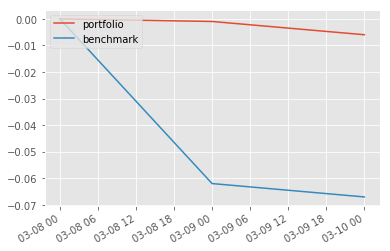

In [9]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.BTC.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)

plt.show()